# 1. 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# 2. 데이터 로드

In [2]:
google_trend_df = pd.read_csv('/content/drive/MyDrive/sogang_thesis_prj/dataset/total_google_trend.csv', index_col=0)
google_trend_df['date'] = pd.to_datetime(google_trend_df['date'])
google_trend_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16511 entries, 0 to 16510
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    16511 non-null  datetime64[ns]
 1   trend   16511 non-null  int64         
 2   artist  16511 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 516.0+ KB


In [3]:
google_trend_test_df = pd.read_excel('/content/drive/MyDrive/sogang_thesis_prj/dataset/test_google_trend.xlsx')
google_trend_test_df['date'] = pd.to_datetime(google_trend_test_df['date'])
google_trend_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    279 non-null    datetime64[ns]
 1   trend   279 non-null    int64         
 2   artist  279 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 6.7+ KB


In [4]:
artist_info_df = pd.read_csv('/content/drive/MyDrive/sogang_thesis_prj/dataset/top5_group_info.csv', index_col=0)
artist_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4839 entries, 0 to 4838
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   artist_name          4839 non-null   object 
 1   artist_id            4839 non-null   object 
 2   debut_date           4839 non-null   object 
 3   artist_types         4839 non-null   object 
 4   member_cnt           4839 non-null   int64  
 5   sub_group_cnt        4839 non-null   int64  
 6   label                4734 non-null   object 
 7   album_id             4839 non-null   object 
 8   album_name           4839 non-null   object 
 9   album_type           4839 non-null   object 
 10  release_date         4839 non-null   object 
 11  main_genre           0 non-null      float64
 12  sub_genre            0 non-null      float64
 13  track_cnt            4839 non-null   int64  
 14  avg_track_play_time  4749 non-null   float64
 15  participant_type     4839 non-null   object

In [5]:
# 앨범 데이터
album_info_df = artist_info_df.drop(['main_genre', 'sub_genre'], axis=1)[['album_name', 'album_type', 'artist_name', 'release_date', 'track_cnt', 'avg_track_play_time']].drop_duplicates()
album_info_df['release_date'] = pd.to_datetime(album_info_df['release_date'])

album_info_df = album_info_df[album_info_df['artist_name'] != 'NCT DREAM']

album_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220 entries, 0 to 4715
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   album_name           220 non-null    object        
 1   album_type           220 non-null    object        
 2   artist_name          220 non-null    object        
 3   release_date         220 non-null    datetime64[ns]
 4   track_cnt            220 non-null    int64         
 5   avg_track_play_time  210 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 12.0+ KB


# 3. 데이터 전처리

In [6]:
def preprocess_google_trend_df(trend_df):

    # 앨범 데이터 추가
    trend_df = trend_df.merge(album_info_df, how='left', left_on=['artist', 'date'], right_on=['artist_name', 'release_date']).drop('artist_name', axis=1)

    # 앨범 발매일 이후 7일 동일 데이터 적용
    # 앨범 초동 판매량 집계 기준일에 따라 7일 적용
    for i, row in trend_df.iterrows():

        artist = row['artist']
        release_date = row['release_date']
        end_date = release_date + pd.Timedelta(days=7)  # 발매일 이후 7일

        # 해당 기간에 데이터 할당
        mask = (trend_df['artist'] == artist) & \
              (trend_df['date'] >= release_date) & (trend_df['date'] < end_date)

        trend_df.loc[mask, 'release_date'] = row['release_date']
        trend_df.loc[mask, 'album_name'] = row['album_name']
        trend_df.loc[mask, 'album_type'] = row['album_type']

        trend_df.loc[mask, 'track_cnt'] = row['track_cnt']
        trend_df.loc[mask, 'avg_track_play_time'] = row['avg_track_play_time']

    trend_df[trend_df['album_name'].isnull() == False]

    # 앨범 장르 인코딩
    train_album_type_df = pd.get_dummies(trend_df['album_type'])
    trend_df = pd.concat([trend_df, train_album_type_df], axis=1)

    # 모든 bool 타입 열을 1/0으로 변환
    trend_df = trend_df.applymap(lambda x: int(x) if isinstance(x, bool) else x)
    trend_df = trend_df.drop(['album_type'], axis=1)

    # 최신 앨범 발매일 도달 기간
    trend_df['release_duration'] = (trend_df['date'] - trend_df['release_date']).dt.days

    return trend_df

In [7]:
def interpolate_trend_df(trend_df):

    trend_df = trend_df.set_index('date')

    # trend2: artist별 time interpolation & backward fill 수행
    # trend3: artist별 trend 지수 추세선 제거 적용
    google_trend_df_list = []
    for artist in trend_df['artist'].unique():

        single_artist_trend_df = trend_df.query(f"artist == '{artist}'")

        # trend3
        decomposition = seasonal_decompose(single_artist_trend_df['trend'], model='additive', period=12)
        trend = decomposition.trend

        single_artist_trend_df['trend3'] = single_artist_trend_df['trend'] - trend
        single_artist_trend_df['trend3'] = single_artist_trend_df['trend3'].interpolate(method='time').fillna(method='bfill')

        # trend2
        single_artist_trend_df.loc[single_artist_trend_df['trend'] == 0, 'trend'] = np.NaN # 0인 trend 값 interpolation 수행
        single_artist_trend_df['trend2'] = single_artist_trend_df['trend'].interpolate(method='time').fillna(method='bfill')

        google_trend_df_list.append(single_artist_trend_df)

    google_trend_df = pd.concat(google_trend_df_list).reset_index().fillna(0) # 나머지 앨범 데이터에 대하여 0으로 결측치 처리

    return google_trend_df

In [8]:
# 아티스트 별 훈련 데이터 기간 통일
# ML 버전에서 사용한 기간에 맞게 모두 2023년 6월 30일 ~ 2024년 6월 30일 동안의 데이터 가져옴
train_df = google_trend_df[google_trend_df['date'].isin([date for date in pd.date_range(start='2023-06-30', end='2024-06-30')])].reset_index(drop=True)

# train 기간 nct dream 0인 trend 값 280일 ==> 해당 케이스 제거
train_df[train_df['trend'] == 0].groupby('artist').count()['date']
train_df = train_df[train_df['artist'] != 'NCT DREAM']

train_df = preprocess_google_trend_df(train_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3307 entries, 0 to 3306
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 3307 non-null   datetime64[ns]
 1   trend                3307 non-null   int64         
 2   artist               3307 non-null   object        
 3   album_name           308 non-null    object        
 4   release_date         308 non-null    datetime64[ns]
 5   track_cnt            308 non-null    float64       
 6   avg_track_play_time  308 non-null    float64       
 7   Album                3307 non-null   int64         
 8   EP                   3307 non-null   int64         
 9   Other                3307 non-null   int64         
 10  Single               3307 non-null   int64         
 11  release_duration     308 non-null    float64       
dtypes: datetime64[ns](2), float64(3), int64(5), object(2)
memory usage: 310.2+ KB


In [9]:
interpolate_train_df = interpolate_trend_df(train_df).drop(['album_name', 'release_date'], axis=1)
interpolate_train_df

,date,trend,artist,track_cnt,avg_track_play_time,Album,EP,Other,Single,release_duration,trend3,trend2
0,2023-06-30,21.0,aespa,0.0,0.0,0,0,0,0,0.0,5.708333,21.0
1,2023-07-01,28.0,aespa,0.0,0.0,0,0,0,0,0.0,5.708333,28.0
2,2023-07-02,19.0,aespa,0.0,0.0,0,0,0,0,0.0,5.708333,19.0
3,2023-07-03,23.0,aespa,0.0,0.0,0,0,0,0,0.0,5.708333,23.0
4,2023-07-04,17.0,aespa,0.0,0.0,0,0,0,0,0.0,5.708333,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3302,2024-06-26,24.0,TWICE,0.0,0.0,0,0,0,0,0.0,-5.333333,24.0
3303,2024-06-27,23.0,TWICE,0.0,0.0,0,0,0,0,0.0,-5.333333,23.0
3304,2024-06-28,20.0,TWICE,0.0,0.0,0,0,0,0,0.0,-5.333333,20.0
3305,2024-06-29,34.0,TWICE,0.0,0.0,0,0,0,0,0.0,-5.333333,34.0


In [10]:
# test기간은 2024년 7월 1일 ~ 2024년 7월 31일
test_df = google_trend_test_df[google_trend_test_df['artist'] != 'NCT DREAM'].copy()
test_df = preprocess_google_trend_df(test_df)
test_df['EP'] = 0; test_df['Other'] = 0
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279 entries, 0 to 278
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 279 non-null    datetime64[ns]
 1   trend                279 non-null    int64         
 2   artist               279 non-null    object        
 3   album_name           21 non-null     object        
 4   release_date         21 non-null     datetime64[ns]
 5   track_cnt            21 non-null     float64       
 6   avg_track_play_time  14 non-null     float64       
 7   Album                279 non-null    int64         
 8   Single               279 non-null    int64         
 9   release_duration     21 non-null     float64       
 10  EP                   279 non-null    int64         
 11  Other                279 non-null    int64         
dtypes: datetime64[ns](2), float64(3), int64(5), object(2)
memory usage: 26.3+ KB


In [11]:
interpolate_test_df = interpolate_trend_df(test_df).drop(['album_name', 'release_date'], axis=1)
interpolate_test_df

,date,trend,artist,track_cnt,avg_track_play_time,Album,Single,release_duration,EP,Other,trend3,trend2
0,2024-07-01,76.0,aespa,0.0,0.000000,0,0,0.0,0,0,3.083333,76.0
1,2024-07-02,87.0,aespa,3.0,194914.333333,0,1,0.0,0,0,3.083333,87.0
2,2024-07-03,100.0,aespa,3.0,194914.333333,0,1,1.0,0,0,3.083333,100.0
3,2024-07-04,96.0,aespa,3.0,194914.333333,0,1,2.0,0,0,3.083333,96.0
4,2024-07-05,67.0,aespa,3.0,194914.333333,0,1,3.0,0,0,3.083333,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...
274,2024-07-27,46.0,TWICE,0.0,0.000000,0,0,0.0,0,0,0.708333,46.0
275,2024-07-28,50.0,TWICE,0.0,0.000000,0,0,0.0,0,0,0.708333,50.0
276,2024-07-29,43.0,TWICE,0.0,0.000000,0,0,0.0,0,0,0.708333,43.0
277,2024-07-30,47.0,TWICE,0.0,0.000000,0,0,0.0,0,0,0.708333,47.0


# 4. 모델 구성
1. 각 아티스트 별 데이터 분할
2. 훈련 데이터를 훈련 & 검증으로 분할 (8:2)
3. 훈련, 검증, test 데이터 피처 스케일링 (TM 방식에서는 적용 안한 상태)
4. Sequential Dataset 생성
5. Data Loader 생성
6. 모델 훈련
7. test 데이터로 최종 모델 예측값 확인

In [12]:
# TM 모델과 달리 추세선 제거 안한 trend 변수 사용 -> 데이터 분할 후 스케일링 시행
# 딥러닝 특성 상, 비선형 관계 학습을 통한 추세 및 계절성 반영 가능
train_df = interpolate_train_df.drop(['trend2', 'trend3'], axis=1)
train_cols = ['artist', 'date', 'track_cnt', 'avg_track_play_time', 'Album', 'EP', 'Other', 'Single', 'release_duration', 'trend']
total_df = train_df[train_cols]
total_df

,artist,date,track_cnt,avg_track_play_time,Album,EP,Other,Single,release_duration,trend
0,aespa,2023-06-30,0.0,0.0,0,0,0,0,0.0,21.0
1,aespa,2023-07-01,0.0,0.0,0,0,0,0,0.0,28.0
2,aespa,2023-07-02,0.0,0.0,0,0,0,0,0.0,19.0
3,aespa,2023-07-03,0.0,0.0,0,0,0,0,0.0,23.0
4,aespa,2023-07-04,0.0,0.0,0,0,0,0,0.0,17.0
...,...,...,...,...,...,...,...,...,...,...
3302,TWICE,2024-06-26,0.0,0.0,0,0,0,0,0.0,24.0
3303,TWICE,2024-06-27,0.0,0.0,0,0,0,0,0.0,23.0
3304,TWICE,2024-06-28,0.0,0.0,0,0,0,0,0.0,20.0
3305,TWICE,2024-06-29,0.0,0.0,0,0,0,0,0.0,34.0


In [13]:
test_df = interpolate_test_df.drop(['trend2', 'trend3'], axis=1)
test_cols = ['artist', 'date', 'track_cnt', 'avg_track_play_time', 'Album', 'EP', 'Other', 'Single', 'release_duration', 'trend']
test_df = test_df[test_cols]
test_df

,artist,date,track_cnt,avg_track_play_time,Album,EP,Other,Single,release_duration,trend
0,aespa,2024-07-01,0.0,0.000000,0,0,0,0,0.0,76.0
1,aespa,2024-07-02,3.0,194914.333333,0,0,0,1,0.0,87.0
2,aespa,2024-07-03,3.0,194914.333333,0,0,0,1,1.0,100.0
3,aespa,2024-07-04,3.0,194914.333333,0,0,0,1,2.0,96.0
4,aespa,2024-07-05,3.0,194914.333333,0,0,0,1,3.0,67.0
...,...,...,...,...,...,...,...,...,...,...
274,TWICE,2024-07-27,0.0,0.000000,0,0,0,0,0.0,46.0
275,TWICE,2024-07-28,0.0,0.000000,0,0,0,0,0.0,50.0
276,TWICE,2024-07-29,0.0,0.000000,0,0,0,0,0.0,43.0
277,TWICE,2024-07-30,0.0,0.000000,0,0,0,0,0.0,47.0


## 4.1 데이터 분할

In [ ]:
# train, valid 데이터셋 분할
def split_dataset(total_df:pd.DataFrame, test_size: float):

    train_df_list = []; valid_df_list = []
    for artist in total_df['artist'].unique():

        single_trend_df = total_df[total_df['artist'] == artist]

        train_df, valid_df = train_test_split(single_trend_df, test_size=test_size, shuffle=False)
        train_df_list.append(train_df)
        valid_df_list.append(valid_df)

    train_df = pd.concat(train_df_list).reset_index(drop=True)
    valid_df = pd.concat(valid_df_list).reset_index(drop=True)

    return train_df, valid_df

train_df, valid_df = split_dataset(total_df, test_size=0.2)
len(train_df), len(valid_df)

(2641, 666)

## 4.2 데이터 스케일링
- 독립변수에 대해서는 특정일자에 나타나는 앨범정보가 적게 나타나도 해당 값 자체로 중요하다고 판단되어 스케일링 skip
- trend 변수에서 이상치가 다수 나타난다고 판단되어 robust scaler 사용

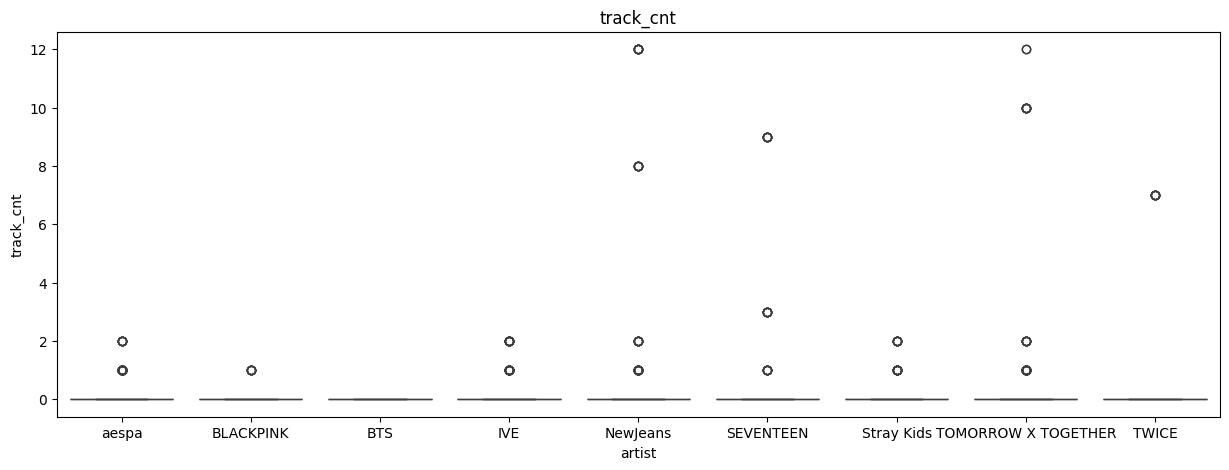

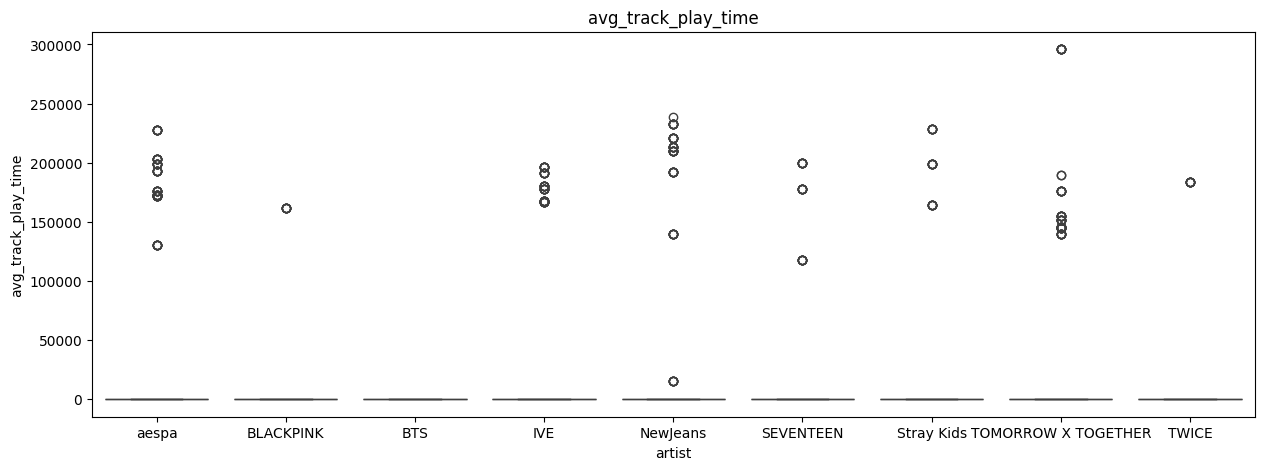

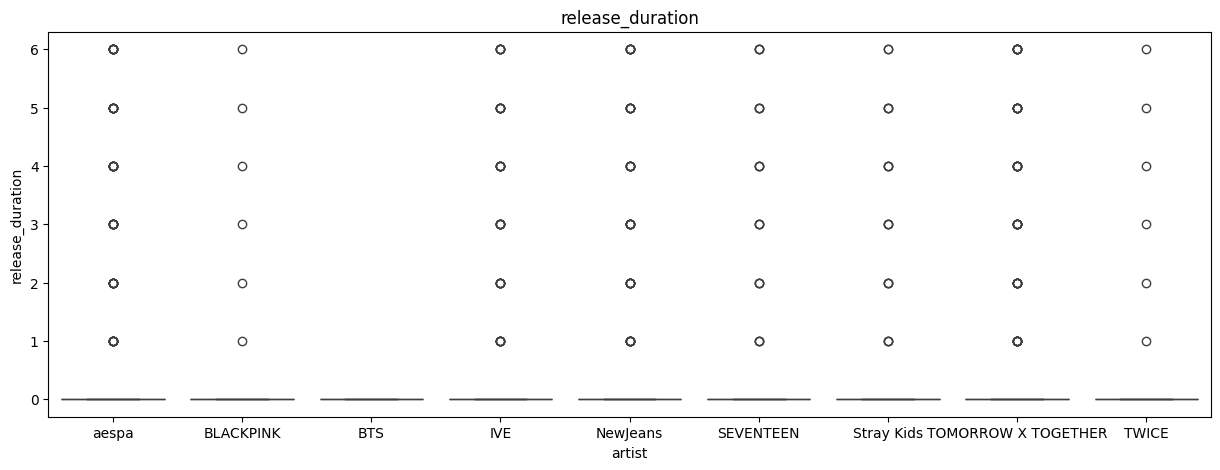

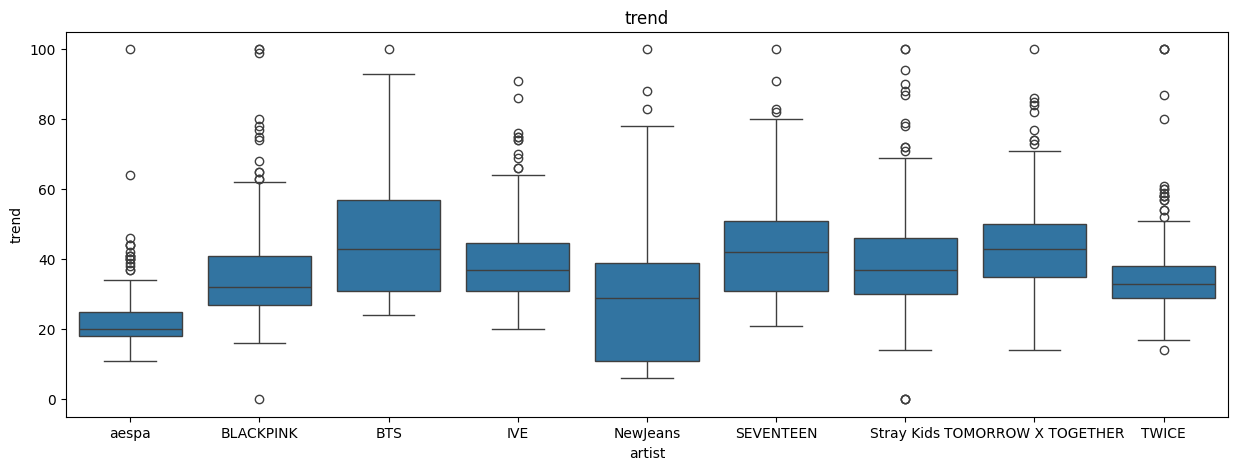

In [ ]:
# 변수 별 분포 파악
for col in ['track_cnt', 'avg_track_play_time', 'release_duration', 'trend']:

    plt.figure(figsize=(15, 5))
    plt.title(col)
    sns.boxplot(data=train_df, y=col, x='artist')
    plt.show()

In [ ]:
train_df_list = []; valid_df_list = []; test_df_list = []
for artist in train_df['artist'].unique():

    single_train_df = train_df[train_df['artist'] == artist]
    single_valid_df = valid_df[valid_df['artist'] == artist]
    single_test_df = test_df[test_df['artist'] == artist]

    # trend 변수 robust 스케일링 수행
    y_train = single_train_df[['trend']]
    y_valid = single_valid_df[['trend']]
    y_test = single_test_df[['trend']]

    # RobustScaler 생성 및 학습 (훈련 데이터에 맞춰서)
    scaler = RobustScaler()
    y_train_scaled = scaler.fit_transform(y_train)

    # 학습된 스케일러를 검증 및 테스트 데이터에 적용
    y_valid_scaled = scaler.transform(y_valid)
    y_test_scaled = scaler.transform(y_test)

    single_train_df['scaled_trend'] = y_train_scaled
    single_valid_df['scaled_trend'] = y_valid_scaled
    single_test_df['scaled_trend'] = y_test_scaled

    train_df_list.append(single_train_df)
    valid_df_list.append(single_valid_df)
    test_df_list.append(single_test_df)

train_df = pd.concat(train_df_list).reset_index(drop=True).drop(['trend'], axis=1)
valid_df = pd.concat(valid_df_list).reset_index(drop=True).drop(['trend'], axis=1)
test_df = pd.concat(test_df_list).reset_index(drop=True).drop(['trend'], axis=1)

## 3.3 데이터셋 구성

In [ ]:
class TimeSeriesDataset(Dataset):

    def __init__(self, data, input_window_size, output_window_size):
        self.data = data
        self.input_window_size = input_window_size
        self.output_window_size = output_window_size

    def __len__(self):
        return len(self.data) - self.input_window_size - self.output_window_size + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.input_window_size, :-1]
        y = self.data[idx+self.input_window_size:idx+self.input_window_size+self.output_window_size, -1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [ ]:
# time series dataset 생성
def generate_dataset(train_df, input_window_size, output_window_size):

    train_df_for_dataset = train_df.copy()

    # 아티스트별로 데이터셋 저장할 딕셔너리 생성
    artist_datasets = {}

    # 아티스트별로 그룹화
    for artist, group_df in train_df_for_dataset.groupby('artist'):

        # 필요한 경우 그룹 내에서 정렬
        group_df = group_df.sort_values(by='date')

        # numpy 배열로 변환
        data = group_df.drop(columns=['date', 'artist']).values

        # 데이터셋 생성
        dataset = TimeSeriesDataset(data, input_window_size, output_window_size)
        artist_datasets[artist] = dataset

    return artist_datasets


input_window_size = 30
output_window_size = 10

dataset_list = []
for df in [train_df, valid_df, test_df]:

    dataset = generate_dataset(df, input_window_size, output_window_size)
    dataset_list.append(dataset)

train_datasets, valid_datasets, test_datasets = dataset_list
len(train_datasets), len(valid_datasets), len(test_datasets)

(9, 9, 9)

## 3.4 데이터로더 생성

In [ ]:
batch_size = 32

dataloader_list = []
for dataset in [train_datasets, valid_datasets, test_datasets]:

    dataloaders = {}
    for artist, dataset in dataset.items():
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        dataloaders[artist] = dataloader

    dataloader_list.append(dataloaders)

train_dataloaders, valid_dataloaders, test_dataloaders = dataloader_list
len(train_dataloaders), len(valid_dataloaders), len(test_dataloaders)

(9, 9, 9)

## 3.5 모델링

In [ ]:
# 모델 정의 (하나의 모델을 모든 아티스트에 대해 학습)
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 모든 아티스트 데이터를 순차적으로 학습
for epoch in range(num_epochs):

    for artist in artist_dataloaders.keys():
        dataloader = artist_dataloaders[artist]

        for batch_x, batch_y in dataloader:

            # 모델 학습 코드
            output = model(batch_x)
            loss = criterion(output, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

NameError: name 'LSTMModel' is not defined